In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import warnings

warnings.filterwarnings("ignore")

In [2]:
datas = pd.read_csv('600905.csv')
x = datas[['open', 'close', 'high', 'low']].values
y = datas['label'].values

In [3]:
def Train(name, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    model = XGBClassifier()
    eval_set = [(x_test, y_test)]
    model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print(name + " Accuracy: %.2f%%" % (accuracy * 100.0))
    print(model.get_params())
    plot_importance(model)
    plt.show()

compare Accuracy: 83.33%
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


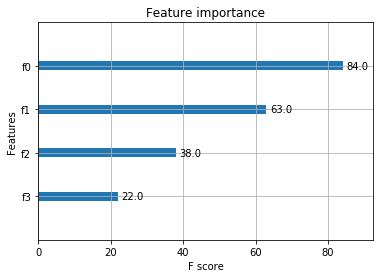

In [4]:
Train('compare', x, y)

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

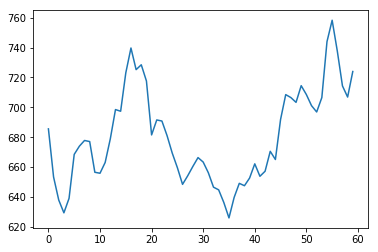

In [6]:
weight = [46, 37, 12, 2]
seq = datas['open'] * weight[0] + datas['close'] * weight[1] + datas['high'] * weight[2] + datas['low'] * weight[3]
seqs = pd.DataFrame(seq)
seqs.columns = ['seq']
plt.plot(seqs)
plt.savefig('pic/600905_fin_index')
plt.show()

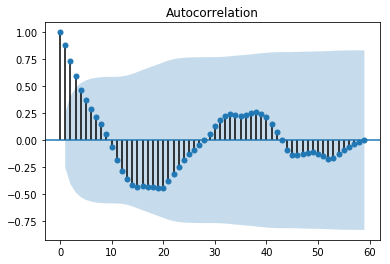

In [7]:
plot_acf(seqs).savefig('pic/600905_fin_index_acf')

In [8]:
print(u'原始序列的ADF结果：',ADF(seqs['seq']))

原始序列的ADF结果： (-2.163847240402634, 0.21962740473073522, 1, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, 387.69434761125774)


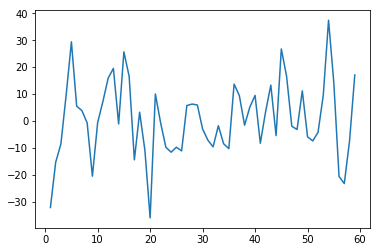

In [9]:
seqs_d = seqs.diff().dropna()
seqs_d.columns=['seq_d']
plt.plot(seqs_d)
plt.show()

差分序列的ADF结果： (-5.351264663803955, 4.284122810736204e-06, 3, 55, {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}, 379.726358679055)
差分序列的白噪声检验结果： (array([4.61586724]), array([0.03167747]))


D:\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


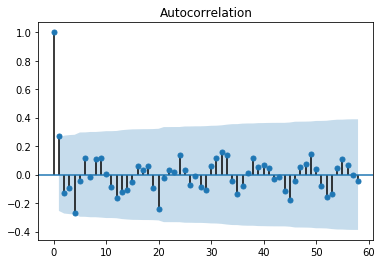

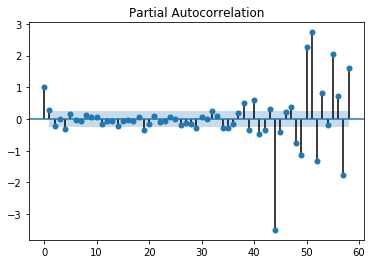

In [10]:
plot_acf(seqs_d).savefig('pic/600905_fin_index_d_acf')
plot_pacf(seqs_d).show()
print(u'差分序列的ADF结果：',ADF(seqs_d['seq_d']))
print(u'差分序列的白噪声检验结果：', acorr_ljungbox(seqs_d, lags=1))

In [11]:
seqs['seq'] = seqs['seq'].astype(float)
pmax = int(len(seqs_d) / 10)
qmax = int(len(seqs_d) / 10)
bic_matrix = []
for p in range(pmax + 1):
    tmp = []
    for q in range(qmax + 1):
        try:
            tmp.append(ARIMA(seqs, (p, 1, q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


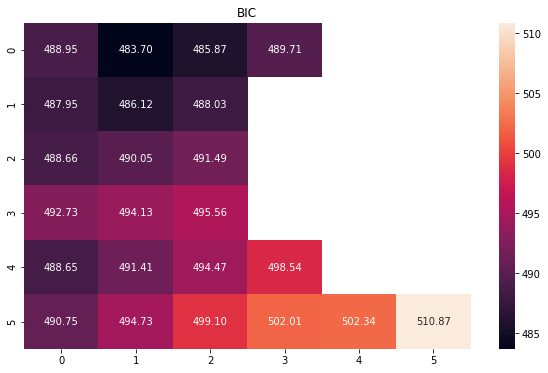

BIC最小的p值和q值：0,1


In [12]:
bic_matrix = pd.DataFrame(bic_matrix)
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.heatmap(bic_matrix, mask = bic_matrix.isnull(), ax = ax, annot = True, fmt = '.2f')
ax.set_title('BIC')
plt.savefig('pic/600905_fin_index_BIC')
plt.show()
p,q = bic_matrix.stack().idxmin()
print(u'BIC最小的p值和q值：%s,%s'%(p,q))

In [13]:
forecastnum = 5
model = ARIMA(seqs, (p,1,q)).fit()
summary = model.summary()
forecast = model.forecast(forecastnum)
print(summary)
print(forecast)

                             ARIMA Model Results                              
Dep. Variable:                  D.seq   No. Observations:                   59
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -235.735
Method:                       css-mle   S.D. of innovations             13.111
Date:                Sat, 23 Apr 2022   AIC                            477.470
Time:                        23:40:47   BIC                            483.703
Sample:                             1   HQIC                           479.903
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5669      2.637      0.215      0.831      -4.602       5.736
ma.L1.D.seq     0.5544      0.140      3.954      0.000       0.280       0.829
                                    Roots       

In [14]:
pred = [733.94903959, 734.51596527, 735.08289096, 735.64981665, 736.21674233]
new_seq = pd.DataFrame(pred)
new_seq.columns = ['seq']
seqs = seqs.append(new_seq)
seqs = seqs.reset_index()
seqs = seqs.drop(['index'], axis = 1)
seqs.tail()

,seq
60,733.949040
61,734.515965
62,735.082891
63,735.649817
64,736.216742


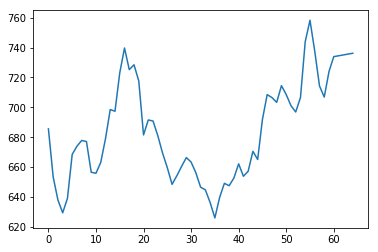

In [15]:
plt.plot(seqs)
plt.savefig('pic/600905_fin_index_pred')
plt.show()

In [16]:
MA10 = []
MA5 = []
for day in range(len(seqs['seq'])):
    if day < 4:
        MA5.append(0)
        MA10.append(0)
    elif day < 9:
        MA5.append(seqs.loc[day - 4:day + 1].mean().values[0])
        MA10.append(0)
    else:
        MA5.append(seqs.loc[day - 4:day + 1].mean().values[0])
        MA10.append(seqs.loc[day - 9:day + 1].mean().values[0])
MA = pd.DataFrame()
MA['MA5'] = MA5
MA['MA10'] = MA10
MA.tail()

,MA5,MA10
60,725.229167,723.479546
61,724.797983,726.564354
62,728.347952,730.086156
63,733.234076,732.784041
64,735.082891,731.663445


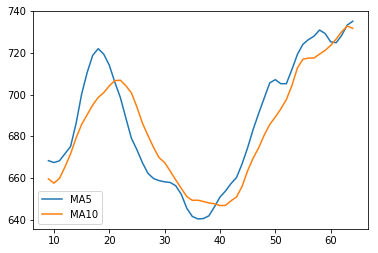

In [17]:
plt.plot(MA['MA5'].loc[9:], label='MA5')
plt.plot(MA['MA10'].loc[9:], label='MA10')
plt.legend(loc='best')
plt.savefig('pic/600905_fin_index_EMA')
plt.show()

In [18]:
flag = MA['MA5'] - MA['MA10']
flag = flag.apply(lambda x: 1 if x >= 0 else 0)

fork_gold = []
fork_dead = []
last = flag[10]
for day in range(11, len(flag)):
    if flag[day] != last:
        if flag[day] == 0:
            fork_dead.append(day)
        else:
            fork_gold.append(day)
        last = flag[day]
print('金叉点: ', fork_gold)
print('死叉点: ', fork_dead)

金叉点:  [40, 63]
死叉点:  [21, 61]


In [19]:
import tushare as ts
fin_datas = ts.get_hist_data('600905', start='2021-10-11', end='2022-01-10')
fin_datas = fin_datas.reset_index()
fin_datas = fin_datas.sort_values('date',ascending=True)
fin_datas = fin_datas.reset_index()
fin_datas = fin_datas.drop(['index', 'date'], axis = 1)
fin_datas

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
0,7.22,7.25,6.84,6.70,6123323.00,-0.30,-4.20,7.174,7.072,6.669,8534272.30,11166295.25,9889276.25,8.81
1,6.70,6.94,6.73,6.45,6047445.00,-0.11,-1.61,7.028,7.083,6.680,7171635.30,10201793.65,9285817.60,8.70
2,6.64,6.64,6.49,6.36,4431096.50,-0.24,-3.57,6.914,7.004,6.686,6291281.80,9061489.70,8883987.98,6.38
3,6.41,6.69,6.53,6.33,4498129.00,0.04,0.62,6.746,6.961,6.685,5460974.00,7970881.50,8573383.63,6.47
4,6.48,6.75,6.68,6.43,4146097.75,0.15,2.30,6.654,6.918,6.692,5049218.25,7173611.78,8191554.66,5.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,7.57,7.69,7.43,7.41,4034471.25,-0.08,-1.06,7.396,7.424,7.268,4577986.80,5541350.35,6329391.93,4.71
61,7.41,7.43,7.20,7.11,4646892.00,-0.23,-3.10,7.342,7.421,7.294,4525999.40,5692952.45,6404435.46,5.42
62,7.12,7.25,7.19,7.09,3178437.00,-0.01,-0.14,7.330,7.431,7.311,4199822.30,5631528.85,6378340.33,3.71
63,7.16,7.21,7.10,7.09,3227437.75,-0.09,-1.25,7.286,7.393,7.315,4072997.80,5072708.83,6231469.99,3.77


In [20]:
price = fin_datas['close'].tolist()
earn = price[fork_dead[-1]] - price[fork_gold[0]]
print('对比每股收益: ', earn)

对比每股收益:  0.4500000000000002
